In [85]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime


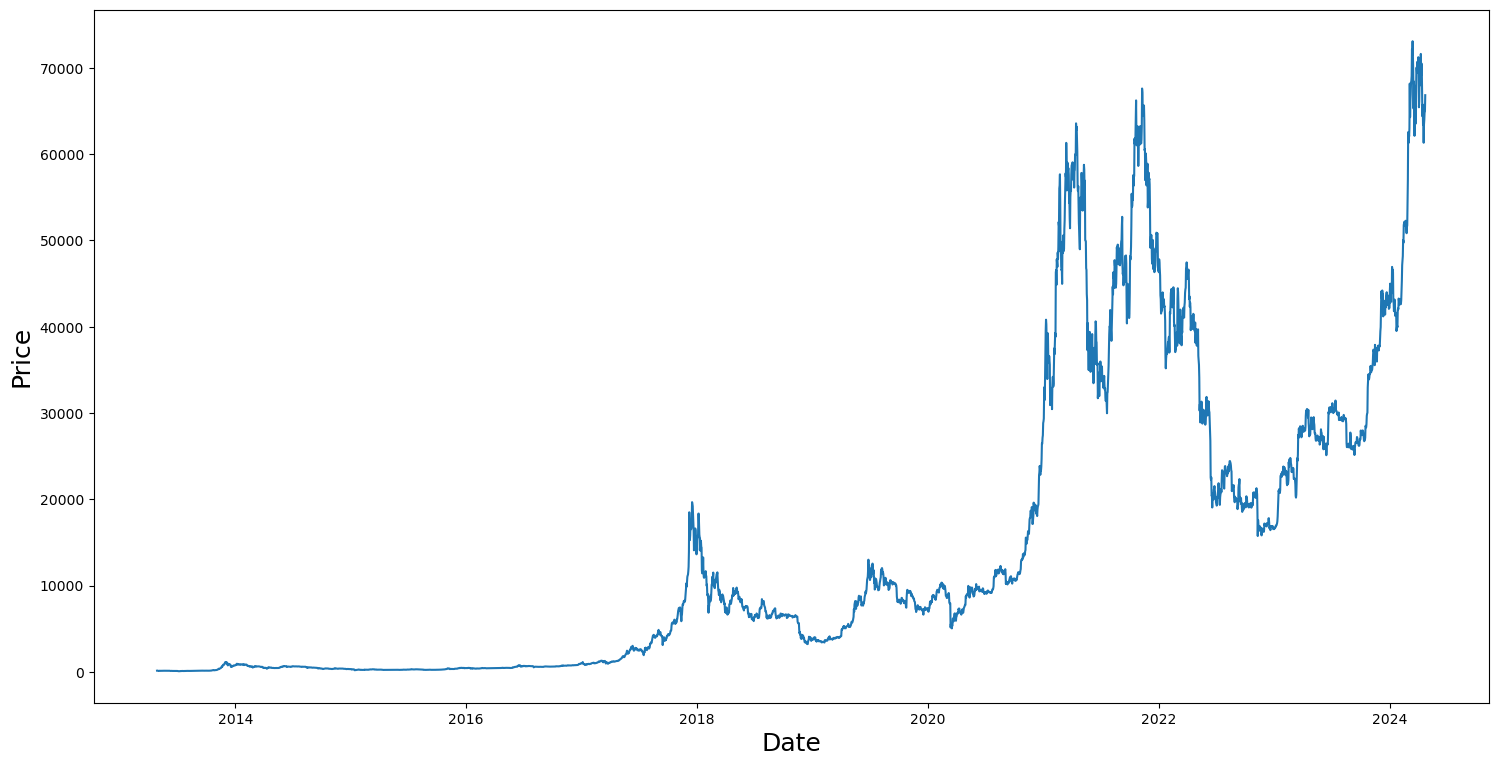

In [88]:
# Load data
full_df = pd.read_csv('btc-usd-max.csv')
df = pd.read_csv('btc-usd-max.csv', usecols=[1], engine='python')

# Preprocess data
full_df['snapped_at'] = pd.to_datetime(full_df['snapped_at'])
full_df['SMA_30'] = full_df['price'].rolling(window=30).mean()
full_df['EMA_30'] = full_df['price'].ewm(span=30, adjust=False).mean()
full_df['SMA_30'] = full_df['SMA_30'].fillna(method='bfill')

# Visualization
plt.figure(figsize = (18,9))
plt.plot(full_df.iloc[:,0], full_df['price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [73]:
price_scaler = MinMaxScaler(feature_range=(0, 1))
SMA_scaler = MinMaxScaler(feature_range=(0,1))
EMA_scaler = MinMaxScaler(feature_range=(0,1))

price_scaler.fit(full_df[['price']])
SMA_scaler.fit(full_df[['SMA_30']])
EMA_scaler.fit(full_df[['EMA_30']])

full_df['price'] = price_scaler.transform(full_df[['price']])
full_df['SMA_30'] = SMA_scaler.transform(full_df[['SMA_30']])
full_df['EMA_30'] = EMA_scaler.transform(full_df[['EMA_30']])


In [101]:
# Convert sequence for LSTM model
def create_sequences(df, seq_length):
    xs, ys = [], []
    data = df[['price', 'SMA_30', 'EMA_30']].values
    for i in range(len(data)-seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(full_df, seq_length)
print(X.shape)

(3982, 30, 3)


In [76]:
# split into testing and training
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [77]:
# Build model
model = Sequential([
    LSTM(50, activation='tanh', return_sequences = True, input_shape=(seq_length, 3)),
    LSTM(50, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Fit model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
94/94 [==============================] - 4s 19ms/step - loss: 0.0022
Epoch 2/20
94/94 [==============================] - 2s 19ms/step - loss: 6.8025e-04
Epoch 3/20
94/94 [==============================] - 2s 19ms/step - loss: 5.0424e-04
Epoch 4/20
94/94 [==============================] - 2s 19ms/step - loss: 3.3467e-04
Epoch 5/20
94/94 [==============================] - 2s 19ms/step - loss: 3.9597e-04
Epoch 6/20
94/94 [==============================] - 2s 19ms/step - loss: 2.9303e-04
Epoch 7/20
94/94 [==============================] - 2s 19ms/step - loss: 2.5110e-04
Epoch 8/20
94/94 [==============================] - 2s 18ms/step - loss: 1.9904e-04
Epoch 9/20
94/94 [==============================] - 2s 18ms/step - loss: 2.0217e-04
Epoch 10/20
94/94 [==============================] - 2s 18ms/step - loss: 2.1816e-04
Epoch 11/20
94/94 [==============================] - 2s 19ms/step - loss: 2.0418e-04
Epoch 12/20
94/94 [==============================] - 2s 19ms/step - loss: 1.58

In [91]:
# Predict
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
allPredict = model.predict(X)


# Rescale 
trainPredict = price_scaler.inverse_transform(trainPredict)
testPredict = price_scaler.inverse_transform(testPredict)
rescaled_X_train = price_scaler.inverse_transform(X_train.reshape(-1, 1))
rescaled_y_train = price_scaler.inverse_transform(y_train.reshape(-1, 1))
rescaled_X_test = price_scaler.inverse_transform(X_test.reshape(-1, 1))
rescaled_y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1))
allPredict = price_scaler.inverse_transform(allPredict)

125/125 [==============================] - 1s 7ms/step


In [90]:
mae = mean_absolute_error(rescaled_y_test, testPredict)
print(mae)

1232.6728289214914
996


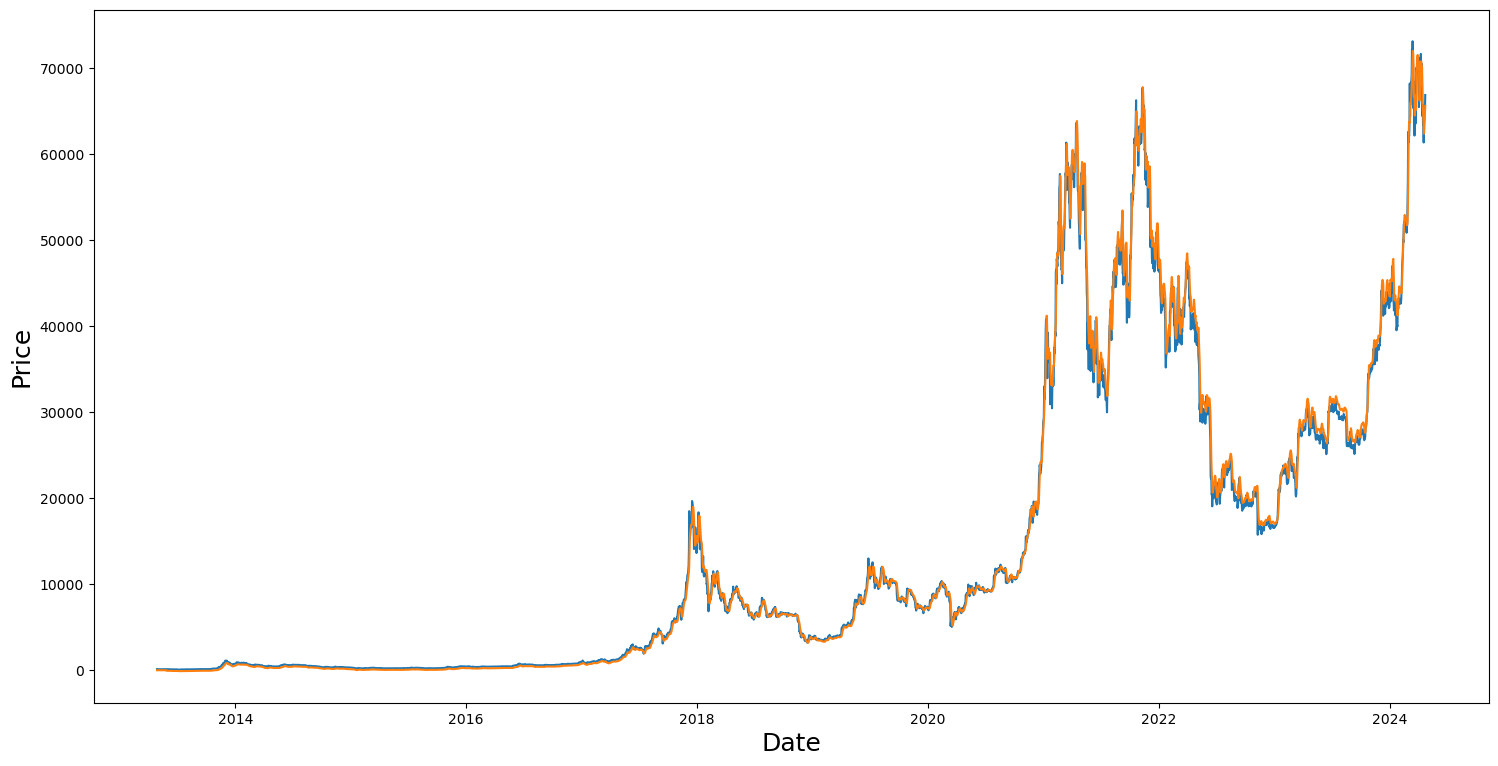

In [106]:
# Visualization
zeros = np.zeros(30)
beginning_and_pred = np.concatenate((zeros,allPredict.flatten())) # Add zeros to the first 30 days, because there are no predictions for these days
plt.figure(figsize = (18,9))
plt.plot(full_df.iloc[:,0], full_df['price'])
plt.plot(full_df.iloc[:,0], beginning_and_pred)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()